# A/B-тестирование

# Постановка задачи

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оцените корректность проведения теста
- Проанализируйте результаты теста.

Чтобы оценить корректность проведения теста, проверьте:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

# Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Загрузка данных и предобработка

### Загрузка данных.Требуется ли преобразование типов?

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth

from scipy import stats as st

from datetime import timedelta
import datetime as dt
from plotly import graph_objects as go

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

**Таблица final_ab_events.csv**

In [4]:
ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv', sep=',')
ab_events.info()
ab_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Тип данных с датой следует заменить на datetime, остальные типы корректные.

In [5]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

**Таблица ab_project_marketing_events.csv**

In [6]:
marketin_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', sep=',')
marketin_events.info()
marketin_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Здесь также типы данных с датой следует заменить на datetime

In [7]:
marketin_events_prob = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', sep=',', parse_dates=['start_dt', 'finish_dt'])
marketin_events_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [8]:
marketin_events['start_dt'] = pd.to_datetime(marketin_events['start_dt'])
marketin_events['finish_dt'] = pd.to_datetime(marketin_events['finish_dt'])

**Таблица final_ab_new_users.csv**

In [9]:
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv', sep=',')
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Здесь тоже тип данных с датой нужно изменить

In [10]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

**Таблица final_ab_participants.csv**

In [11]:
ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv', sep=',')
ab_participants.info()
ab_participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Здесь типы данных корректны

### Опишите природу пропущенных значений и дубликатов, если их обнаружите.

In [12]:
print('дубликаты:', ab_events.duplicated().sum())
print('пропуски:',ab_events.isna().sum())

дубликаты: 0
пропуски: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


В графе дополнительные данные о событии 377577 пропусков, так как информация допольнительная, скорее всего к заполнению не обязательна, поэтому оставим пропущенные значения без изменений,дубликатов нет

In [13]:
print('дубликаты:', marketin_events.duplicated().sum())
print('пропуски:',marketin_events.isna().sum())

дубликаты: 0
пропуски: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


Здесь все в порядке - дубликатов нет, пропусков тоже

In [14]:
print('дубликаты:', new_users.duplicated().sum())
print('пропуски:',new_users.isna().sum())

дубликаты: 0
пропуски: user_id       0
first_date    0
region        0
device        0
dtype: int64


Здесь тоже, ни дубликатов, ни пропусков

In [15]:
print('дубликаты:', ab_participants.duplicated().sum())
print('пропуски:',ab_participants.isna().sum())

дубликаты: 0
пропуски: user_id    0
group      0
ab_test    0
dtype: int64


И здесь дубликатов нет. пропусков нет

## Оцените корректность проведения теста

### Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания

Проверим информацию о проводимых тестах

In [16]:
ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Найдем участников, которые принимали участие в двух тестах сразу и удалим их, так как мы не знаем, пересекались эти тесты или нет, и на каких условиях проводился второй  тест.

In [17]:
ab_participants_2test = ab_participants.groupby('user_id', as_index=False)['ab_test'].count()
ab_participants_2test[ab_participants_2test['ab_test']==2].count()

user_id    1602
ab_test    1602
dtype: int64

участников двух тестов оказалось 1602

Объединим таблиу с количеством тестов с исходной таблицей

In [18]:
ab_participants = ab_participants.merge(ab_participants_2test, on='user_id', how='left')
ab_participants

,user_id,group,ab_test_x,ab_test_y
0,D1ABA3E2887B6A73,A,recommender_system_test,1
1,A7A3664BD6242119,A,recommender_system_test,1
2,DABC14FDDFADD29E,A,recommender_system_test,2
3,04988C5DF189632E,A,recommender_system_test,2
4,482F14783456D21B,B,recommender_system_test,1
...,...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test,1
18264,3DE51B726983B657,A,interface_eu_test,1
18265,F501F79D332BE86C,A,interface_eu_test,1
18266,63FBE257B05F2245,A,interface_eu_test,1


Отберем участников только с одним тестом

In [19]:
ab_participants = ab_participants.query('ab_test_y==1')
ab_participants

,user_id,group,ab_test_x,ab_test_y
0,D1ABA3E2887B6A73,A,recommender_system_test,1
1,A7A3664BD6242119,A,recommender_system_test,1
4,482F14783456D21B,B,recommender_system_test,1
5,4FF2998A348C484F,A,recommender_system_test,1
6,7473E0943673C09E,A,recommender_system_test,1
...,...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test,1
18264,3DE51B726983B657,A,interface_eu_test,1
18265,F501F79D332BE86C,A,interface_eu_test,1
18266,63FBE257B05F2245,A,interface_eu_test,1


В данных присутствуют 2 разных теста, согласно ТЗ в дальнейшем будем исаользовать тест recommender_system_test - отберем нужные данные. 

In [20]:
participants_rst = ab_participants.query('ab_test_x == "recommender_system_test"')
participants_rst

,user_id,group,ab_test_x,ab_test_y
0,D1ABA3E2887B6A73,A,recommender_system_test,1
1,A7A3664BD6242119,A,recommender_system_test,1
4,482F14783456D21B,B,recommender_system_test,1
5,4FF2998A348C484F,A,recommender_system_test,1
6,7473E0943673C09E,A,recommender_system_test,1
...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,1
6697,9D263B8EF15CF188,B,recommender_system_test,1
6698,F2FBBA33F37DEC46,A,recommender_system_test,1
6699,29C92313A98B1176,B,recommender_system_test,1


После отбора нужного теста колчество участников стало 5099. Проверим наличие обеих групп в тесте:

In [21]:
participants_rst['group'].value_counts()

A    2903
B    2196
Name: group, dtype: int64

Группа А содержит 2903 участников, группа В - 2196 участников. Проверим период проведения теста:

In [22]:
print('Min дата события:',  ab_events['event_dt'].min())
print('Max дата события:',  ab_events['event_dt'].max())

Min дата события: 2020-12-07 00:00:33
Max дата события: 2020-12-30 23:36:33


Согласно ТЗ тест проводился в период с 2020-12-07 по 2021-01-04. У нас же данные только по 30 декабря, скорее всего случилась какая-то ошибка в выгрузке. ПРоверим дату остановки набора новых пользователей: 2020-12-21.

In [23]:
print('Max дата события:', new_users['first_date'].max())

Max дата события: 2020-12-23 00:00:00


Набор новых пользователей должен был проекратиться 21 декабря, у нас же есть данные по 23 декабря - нарушение - отберем данные в соответствии ТЗ.

In [24]:
new_users = new_users.query('first_date <= "2020-12-21"')
new_users.sort_values(by='first_date', ascending=False)

,user_id,first_date,region,device
11634,70F36230F9B8638B,2020-12-21,EU,Android
13339,835A6CDC7B175A51,2020-12-21,EU,Android
13341,E882FE66AA0D9C75,2020-12-21,EU,Mac
13342,C1015548222FFF3B,2020-12-21,EU,iPhone
13343,F2C2AC35F5B746F1,2020-12-21,N.America,Android
...,...,...,...,...
3734,C6435CD7B8A161E7,2020-12-07,EU,Android
3735,93384A9D3598C56B,2020-12-07,EU,iPhone
3736,CF163150ADFA1C7C,2020-12-07,N.America,Android
3737,F41040A15B0AC503,2020-12-07,EU,PC


In [25]:
new_users['region'].value_counts()

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

Text(0.5, 0, 'Регион')

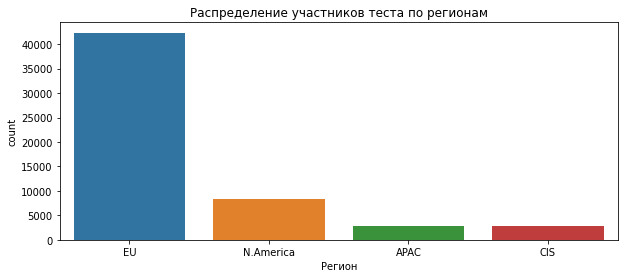

In [26]:
list=['EU', 'N.America', 'APAC', 'CIS']
plt.figure(figsize=(10,4))
sns.countplot(new_users['region'], x=list)
plt.title('Распределение участников теста по регионам')
plt.xlabel('Регион')

Распределение по регионам выполненро неравномерно, возможно, следует изучать каждый регион в отдельности.

Выполним требование ТЗ по аудитории: 15% новых пользователей из региона EU

In [27]:
new_users = new_users.query('region == "EU"')
print('% новых пользователей из региона "Европа": {:.2f}%'.format(len(participants_rst)/len(new_users)*100))

% новых пользователей из региона "Европа": 12.04%


После удаления участников обоих тестов процент новых пользователей из Европы сократился до 12%.

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

Так как целевая аудитория у нас пользователи из Европы, посмотрим, какие маркетинговые компании проводились в этом регионе, дата проведения теста - 2020-12-07 по 2021-01-04.

In [28]:
marketin_events_eu = marketin_events.query('regions!="APAC" & regions!="CIS" & regions!="N.America"')
marketin_events_eu.sort_values(by='start_dt', ascending=False)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


Таким образом видно, что в период проведения теста проводилась рекламная кампания "Christmas&New Year Promo", которая могла повлиять на результат теста, также дата проведения теста совпадает с новогодними праздниками, что также может плачевно сказаться на проведении тестов - так как обычное поведение пользователей в этот период сильно меняется

### Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования

Объединим таблицу с поьзователями с таблицей участников тестов

In [29]:
users_test = new_users.merge(
    participants_rst, on='user_id', how='left').dropna()
users_test['region'].value_counts()

EU    4749
Name: region, dtype: int64

Удалим уже ненужный столбец с количеством тестов

In [30]:
users_test = users_test.drop(columns='ab_test_y')
users_test

,user_id,first_date,region,device,group,ab_test_x
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
16,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
28,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
47,16C69ED14DA9F4A8,2020-12-07,EU,PC,B,recommender_system_test
50,3C5DD0288AC4FE23,2020-12-07,EU,PC,A,recommender_system_test
...,...,...,...,...,...,...
42298,3CA972F86411CF13,2020-12-20,EU,PC,A,recommender_system_test
42308,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
42319,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test
42320,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test


Проверим пересечение участников в двух группах теста

In [31]:
user_test_ab=users_test.groupby('user_id').agg({'group' : 'nunique'}).reset_index()
user_test_ab = user_test_ab.query('group==2').count()
user_test_ab

user_id    0
group      0
dtype: int64

Пересечений учпстников в группах нет. Таким образом конечное число участникорв теста - 4749, что ниже требований ТЗ

In [32]:
users_test['group'].value_counts()

A    2713
B    2036
Name: group, dtype: int64

Группа А содержит 2713 участников, что на 677 участников больше, чем группа Б(2036). Добавим к таблице с участниками таблицу с событиями

In [33]:
users_test = users_test.merge(ab_events, on='user_id', how='left')
users_test

,user_id,first_date,region,device,group,ab_test_x,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
2,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07 06:50:29,purchase,4.99
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,2020-12-09 02:19:17,purchase,99.99
4,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07 06:50:30,product_cart,NaN
...,...,...,...,...,...,...,...,...,...
19676,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN
19677,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN
19678,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN
19679,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:49,login,NaN


In [34]:
users_test['region'].value_counts()

EU    19681
Name: region, dtype: int64

## Проведите исследовательский анализ данных:

### Количество событий на пользователя одинаково распределены в выборках? 

Найдем среднее количество событий на каждого пользователа по каждой из групп

In [35]:
user_event = users_test.groupby(['user_id', 'group'])['event_name'].count().reset_index()
user_event.head()

,user_id,group,event_name
0,000ABE35EE11412F,A,0
1,0010A1C096941592,A,12
2,001C05E87D336C59,A,0
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


In [36]:
print('Среднее количество событий на пользователя в группе А:', user_event.query('group == "A"')['event_name'].mean())
print('Среднее количество событий на пользователя в группе B:', user_event.query('group == "B"')['event_name'].mean())

Среднее количество событий на пользователя в группе А: 5.065241430151124
Среднее количество событий на пользователя в группе B: 1.8585461689587426


Количество событий на пользователя распределены между выборками неодинаково.

### Как число событий в выборках распределено по дням?

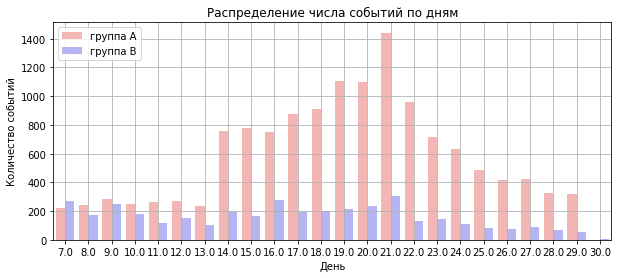

In [37]:
users_test['day'] = users_test['event_dt'].dt.day

plt.figure(figsize =(10, 4))
#Строим график
sns.countplot(data=users_test, x='day', hue='group', palette="bwr_r")
#Зададим заголовок
plt.title('Распределение числа событий по дням')
#Подишем ось x
plt.xlabel('День')
#Подпишем ось y
plt.ylabel('Количество событий')
plt.grid()
plt.legend(labels=['группа А', 'группа В'])
plt.show()  

Группа А сильно отличается по событиям от группы В, с 14 числа пошел резкий подъем количества событий, пик достиг 21 декабря, как раз в дату остановки теста. Не очень удачный период для проведения "правдивого" теста.

### Как меняется конверсия в воронке в выборках на разных этапах?

In [38]:
events_users = users_test.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).reindex(["login", "product_page", "product_cart", "purchase"])
events_users 

group,A,B
event_name,,
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


Количество событий "покупки" больше чем количество событий "просмотри корзины". Это означает, что ворнка у нас нестрогая, и можно приобрести товар минуя посещение корзины. События "логин" и просмотр карточки товара распределены логично.

In [39]:
fig = go.Figure()
event_name=['login', 'product_page', 'product_cart', 'purchase']
for group in events_users.iloc[:, :2].iteritems():
    fig.add_trace(go.Funnel(
        name = group[0],
        orientation = "h",
        y = event_name,
        x = group[1],
        textinfo = "value + percent previous"
    ))
    
fig.update_layout(
    title = 'Продуктовая воронка с конверсией к предыдущему шагу',
    autosize=True,
)

fig.show()

На шаге от события "product_page" к событию "purchase" больше всего теряется пользователей.

## Оцените результаты A/B-тестирования

### Проверьте статистическую разницу долей z-критерием

In [40]:
users_a = users_test.query('group == "A"')['user_id'].nunique()
users_a

2713

In [41]:
users_b = users_test.query('group == "B"')['user_id'].nunique()
users_b

2036

In [42]:
events_users

group,A,B
event_name,,
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


In [43]:
def z_test(gr1, gr2, event, alpha):
    users_a = users_test.query('group == "A"')['user_id'].nunique()
    users_b = users_test.query('group == "B"')['user_id'].nunique()
    p1 = events_users.loc[event, gr1]/users_a 
    p2 = events_users.loc[event, gr2]/users_b
    p_combined = (events_users.loc[event, gr1] + events_users.loc[event, gr2]) / (users_a + users_b)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users_a + 1 / users_b)) # ваш код
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # ваш код
    print('p-значение: ', p_value)
    if p_value < alpha: # ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

In [44]:
for event in events_users.index:
    z_test('A', 'B', event, 0.05)
    print()

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница



In [45]:
1e-324

0.0

## Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

В ходе анализа выяснилось, в данных присутствуют 2 разных теста, участников двух тестов оказалось 1602, согласно ТЗ необходимо было исследовать тест recommender_system_test, поэтому эти участники были исключены из исследования. После отбора нужного теста колчество участников стало 5099. Проверка наличия обеих групп в тесте показала, что группа А содержит 2903 участников, группа В - 2196 участников. Набор новых пользователей должен был проекратиться 21 декабря, у нас были данные по 23 декабря, что  также не сообвествовало ТЗ, такие данные были также исключены. Распределение участников по регионам выполненро неравномерно. Требование ТЗ по аудитории: 15% новых пользователей из региона EU фактически не было выполнено и составило 12.04%. В результате исследования маркетинговыз активностей выявлено, что в период проведения теста проводилась рекламная кампания "Christmas&New Year Promo", которая могла повлиять на результат теста, также дата проведения теста совпадает с новогодними праздниками, что негативно сказывается на корректности проведения теста. Пересечений участников в группах теста не обнаружено, однако их количество распределено неодинаково. Таким образом конечное число участникоов теста - 4749, что ниже требований ТЗ в 6000. Среднее количество событий на пользователя в группе А - 5, среднее количество событий на пользователя в группе B -  1.9.
Количество событий на пользователя распределены между выборками неодинаково. Группа А сильно отличается по событиям от группы В, с 14 числа пошел резкий подъем количества событий, пик достиг 21 декабря. По результатам исследования воронки продаж выяснили, что воронка нестрогая, на шаге от события "product_page" к событию "purchase" больше всего теряется пользователей.Результат проверки z-теста показал Они говорят нам о слишком большом различии между группами. Подытожив вышеперичисленное, можно сделать вывод, что результатам теста доверять нельзя, тест проведен с множеством нарушений.
   
</div>